## The Battle of Neighborhoods: Final Capstone Project

### Libraries and Imports

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

### Scraping Wikipedia table and data cleaning

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, "html.parser")
soup.find_all('title')

[<title>List of postal codes of Canada: M - Wikipedia</title>]

In [3]:
#Data scraping, including ignoring cells with a borough that is 'Not assigned'
table_contents=[]
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)


In [4]:
#Further cleaning
table1 = pd.DataFrame(table_contents)
table1['Borough']=table1['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

table1['Neighborhood']=table1['Neighborhood'].replace({'Ontario Provincial Government': "Queen's Park"})

In [5]:
table1.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Queen's Park


In [6]:
table1.tail()

,PostalCode,Borough,Neighborhood
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."
102,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [7]:
#Checking for any 'Not assigned' neighborhood
table1.Neighborhood.str.count("Not assigned").sum()

0

In [8]:
table1.shape

(103, 3)

### Preparing and merging Geospatial data with neighborhood data

In [9]:
table2 = pd.read_csv("https://cocl.us/Geospatial_data")
table2 = table2.rename(columns={'Postal Code':'PostalCode'})
table2.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
#Merging data
df = pd.merge(table1, table2, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [11]:
#Shape of the dataframe
print('Shape of the dataframe is', df.shape)

Shape of the dataframe is (103, 5)


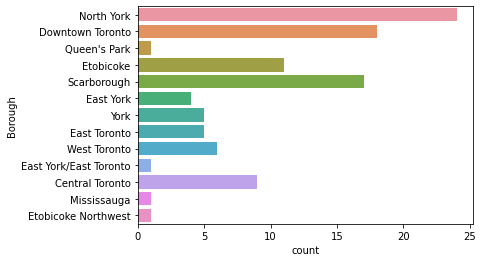

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.countplot(y='Borough', data=df)
plt.savefig('data1.png', bbox_inches='tight')

### Exploring and clustering the neighborhoods in Toronto

In [13]:
# !pip install geopy
# !pip install folium

In [14]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [15]:
##I'll work with boroughs that contain the word Toronto
toronto_df=df[df['Borough'].str.contains("Toronto")]
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [16]:
toronto_df.shape

(39, 5)

In [17]:
print(toronto_df['Borough'].unique())

['Downtown Toronto' 'East Toronto' 'West Toronto' 'East York/East Toronto'
 'Central Toronto']


In [18]:
#Values of each Borough 
toronto_df['Borough'].value_counts()

Downtown Toronto          18
Central Toronto            9
West Toronto               6
East Toronto               5
East York/East Toronto     1
Name: Borough, dtype: int64

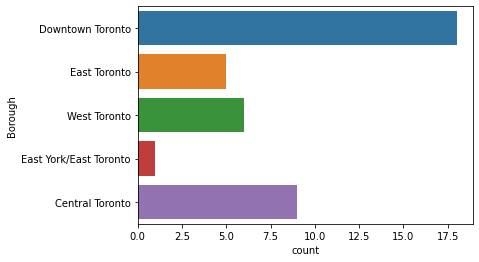

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.countplot(y='Borough', data=toronto_df)
plt.savefig('data2.png', bbox_inches='tight')

##### Next, I'm going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [20]:
#Foursquare Credentials and Version
CLIENT_ID = '1PTKVBJBKOBX3QAUCJDRRZROSAJKXUY2N1C2LDBU0A1KD11O' # your Foursquare ID
CLIENT_SECRET = 'BGETJNUNQSAZUSBYFK3TKNFX5RIMSCIHB2PXQDZ4TTXMGJMH' # your Foursquare Secret
VERSION = '20210522'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1PTKVBJBKOBX3QAUCJDRRZROSAJKXUY2N1C2LDBU0A1KD11O
CLIENT_SECRET:BGETJNUNQSAZUSBYFK3TKNFX5RIMSCIHB2PXQDZ4TTXMGJMH


In [21]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        #Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [23]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [24]:
#Checking how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,61,61,61,61,61,61
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34
Davisville North,7,7,7,7,7,7


In [25]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop                        150
Café                                83
Restaurant                          50
Italian Restaurant                  42
Hotel                               41
Park                                36
Japanese Restaurant                 32
Bakery                              32
Pizza Place                         30
Seafood Restaurant                  24
Gym                                 23
Clothing Store                      23
Bar                                 21
Sushi Restaurant                    21
Sandwich Place                      20
Thai Restaurant                     19
Pub                                 19
Gastropub                           18
Cocktail Bar                        18
Breakfast Spot                      17
American Restaurant                 17
Bookstore                           16
Vegetarian / Vegan Restaurant       16
Beer Bar                            16
Deli / Bodega                       15
Grocery Store            

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 230 uniques categories.


In [27]:
toronto_venues['Venue Category'].unique()

array(['Bakery', 'Coffee Shop', 'Distribution Center', 'Restaurant',
       'Spa', 'Park', 'Breakfast Spot', 'Gym / Fitness Center',
       'Historic Site', 'Farmers Market', 'Chocolate Shop', 'Pub',
       'Dessert Shop', 'Performing Arts Venue', 'Yoga Studio',
       'Mexican Restaurant', 'Café', 'Theater', 'Asian Restaurant',
       'French Restaurant', 'Event Space', 'Shoe Store', 'Art Gallery',
       'Cosmetics Shop', 'Electronics Store', 'Bank', 'Beer Store',
       'Hotel', 'Antique Shop', 'Clothing Store', 'Pizza Place',
       'Burrito Place', 'Comic Shop', 'Plaza', 'Music Venue',
       'Thai Restaurant', 'Burger Joint', 'Sandwich Place',
       'Ramen Restaurant', 'Diner', 'Japanese Restaurant', 'Steakhouse',
       'Tanning Salon', 'Fast Food Restaurant', 'Sporting Goods Shop',
       'Shopping Mall', 'College Rec Center',
       'Modern European Restaurant', 'Gastropub', 'Tea Room',
       'Movie Theater', 'Lake', 'Middle Eastern Restaurant', 'Lounge',
       'Bookstore',

In [28]:
"Thai Restaurant" in toronto_venues['Venue Category'].unique()

True

In [29]:
toronto_venues['Venue Category'].value_counts()['Thai Restaurant']

19

### Analyzing Each Neighborhood

In [30]:
#One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#Adding neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

#Moving neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(1568, 230)

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3,0,0,0,1,1,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,4,6,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,3,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [32]:
pd.set_option('mode.chained_assignment', None)
toronto_grouped1 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Restaurant')]
toronto_grouped1['Total Restaurants'] = toronto_grouped1.sum(axis=1)
#Adding back Neighborhood column and resetting index so that we can manipulate its data.
toronto_grouped1['Neighborhood'] = toronto_grouped['Neighborhood'] 
toronto_grouped1.set_index('Neighborhood', inplace = True)
toronto_grouped1.reset_index(inplace=True)
toronto_grouped1.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total Restaurants
0,Berczy Park,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,1,0,0,1,0,12
1,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2
2,"CN Tower, King and Spadina, Railway Lands, Har...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Central Bay Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,4,2,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,2,0,0,1,0,17
4,Christie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


In [33]:
toronto_group = toronto_grouped1[['Neighborhood','Total Restaurants']]
toronto_group.head()

,Neighborhood,Total Restaurants
0,Berczy Park,12
1,"Brockton, Parkdale Village, Exhibition Place",2
2,"CN Tower, King and Spadina, Railway Lands, Har...",0
3,Central Bay Street,17
4,Christie,2


In [34]:
thai_freq = toronto_grouped[["Neighborhood", "Thai Restaurant"]]
thai_freq.head()

,Neighborhood,Thai Restaurant
0,Berczy Park,1
1,"Brockton, Parkdale Village, Exhibition Place",0
2,"CN Tower, King and Spadina, Railway Lands, Har...",0
3,Central Bay Street,2
4,Christie,0


In [35]:
toronto_thai_total = pd.merge(thai_freq, toronto_group, on='Neighborhood')
toronto_thai_total = toronto_thai_total.sort_values(by=['Thai Restaurant','Total Restaurants'], ascending=[False,False])
toronto_thai_total.head()

,Neighborhood,Thai Restaurant,Total Restaurants
25,"Richmond, Adelaide, King",3,24
12,"First Canadian Place, Underground city",2,31
6,"Commerce Court, Victoria Hotel",2,29
3,Central Bay Street,2,17
16,"High Park, The Junction South",2,8


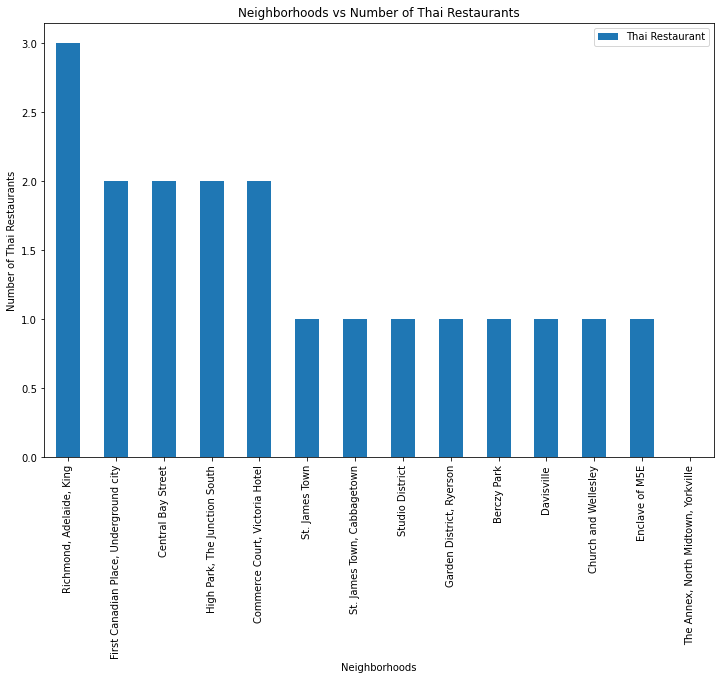

In [36]:
graph = pd.DataFrame(toronto_thai_total.groupby('Neighborhood')['Thai Restaurant'].sum())
graph = graph.sort_values(by ='Thai Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(12,8))
plt.xlabel("Neighborhoods")
plt.ylabel("Number of Thai Restaurants")
plt.title("Neighborhoods vs Number of Thai Restaurants")
plt.savefig('data3.png', bbox_inches='tight')
plt.show()

### Discovering each neighborhood with the top 10 most common restaurants

In [37]:
#Getting the top 10 most common restaurants in each neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create columns according to number of top cuisine
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cuisine'.format(ind+1))

#Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped1['Neighborhood']

for ind in np.arange(toronto_grouped1.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
0,Berczy Park,Total Restaurants,Seafood Restaurant,Restaurant,Greek Restaurant,Indian Restaurant,Japanese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,French Restaurant,Thai Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Total Restaurants,Restaurant,Italian Restaurant,Tibetan Restaurant,Theme Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,"CN Tower, King and Spadina, Railway Lands, Har...",Total Restaurants,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,Central Bay Street,Total Restaurants,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Portuguese Restaurant,Falafel Restaurant,French Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,Christie,Total Restaurants,Restaurant,Italian Restaurant,Tibetan Restaurant,Theme Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


In [38]:
#Preparing data for Clustering 
toronto_grouped2 = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped2.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.016949,0.050847,0.000000,0.000000,0.0,0.016949,0.016949,0.0,0.033898,0.0,0.0,0.016949,0.000000,0.0,0.0,0.016949,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.016949,0.0,0.0000,0.0,0.033898,0.0,0.0,0.0,0.000000,0.016949,0.067797,0.101695,0.0,0.0,0.0,0.0,0.016949,0.000000,0.016949,0.000000,0.0,0.0,0.016949,0.0,0.0,0.0,0.000000,0.016949,0.0,0.016949,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949,0.0,0.0,0.0,0.0,0.000000,0.033898,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.016949,0.016949,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.01

In [39]:
#For Clustering
thai_freq2 = toronto_grouped2[["Neighborhood", "Thai Restaurant"]]
thai_freq2.head(10)

,Neighborhood,Thai Restaurant
0,Berczy Park,0.016949
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
3,Central Bay Street,0.032787
4,Christie,0.000000
5,Church and Wellesley,0.012658
6,"Commerce Court, Victoria Hotel",0.020000
7,Davisville,0.029412
8,Davisville North,0.000000
9,"Dufferin, Dovercourt Village",0.000000


### Clustering Neighborhoods of Toronto

In [40]:
#First I'll find the best K using the Elbow Point method
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = thai_freq2.drop(['Neighborhood'], axis=1)

In [41]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [42]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [43]:
scores = [get_inertia(x) for x in range(2, 10)]

Text(0, 0.5, 'Error')

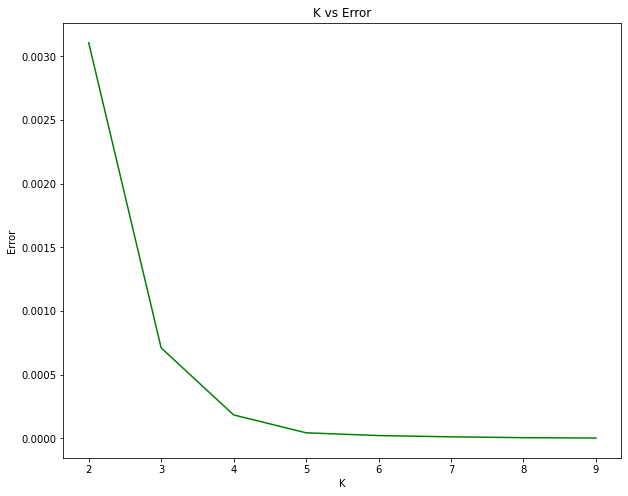

In [44]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 10), y=scores, color='g')
plt.title("K vs Error")
plt.xticks(range(2, 10))
plt.xlabel("K")
plt.ylabel("Error")

In [45]:
#!pip install yellowbrick

In [46]:
import yellowbrick
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

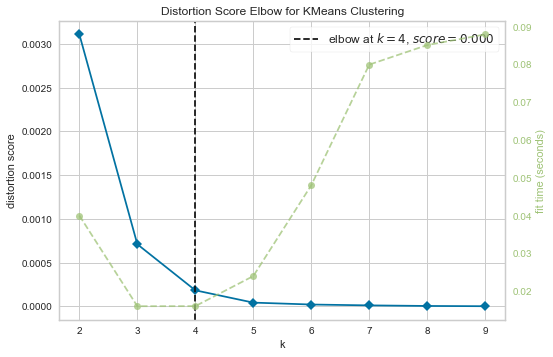

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# Getting the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)        # Fit the data to the visualizer

plt.savefig('data4.png', bbox_inches='tight')
visualizer.show()

#### However, upon checking, I see that Cluster 3 (4th cluster) contains only one neighborhood. So, we should make 3 clusters

In [48]:
#Set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

#Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 0, 2, 0, 1, 2, 2, 2])

In [49]:
#Create a new dataframe that includes the cluster
toronto_merge1 = thai_freq2.copy()

#Add clustering labels
toronto_merge1["Cluster Labels"] = kmeans.labels_
toronto_merge1.head()

,Neighborhood,Thai Restaurant,Cluster Labels
0,Berczy Park,0.016949,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,2
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,2
3,Central Bay Street,0.032787,0
4,Christie,0.000000,2


In [50]:
#Merge with toronto data to add latitude/longitude for each neighborhood
toronto_merge2 = toronto_merge1.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")
print(toronto_merge2.shape)
toronto_merge2.head()

(1568, 9)


,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.016949,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar
0,Berczy Park,0.016949,0,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [51]:
#Sort the results by Cluster Labels
toronto_merge2.sort_values(["Cluster Labels"], inplace=True)
toronto_merge2.head(10)

,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
29,St. James Town,0.012500,0,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint
29,St. James Town,0.012500,0,43.651494,-79.375418,Hawthorne Food and Drink,43.652270,-79.376318,Gastropub
29,St. James Town,0.012500,0,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
29,St. James Town,0.012500,0,43.651494,-79.375418,Pearl Diver,43.651481,-79.373600,Gastropub
29,St. James Town,0.012500,0,43.651494,-79.375418,Dineen Coffee,43.650497,-79.378765,Café
29,St. James Town,0.012500,0,43.651494,-79.375418,Richmond Station,43.651569,-79.379266,American Restaurant
29,St. James Town,0.012500,0,43.651494,-79.375418,Cambridge Suites Toronto,43.651836,-79.378107,Hotel
29,St. James Town,0.012500,0,43.651494,-79.375418,Portico,43.651856,-79.378055,Restaurant
29,St. James Town,0.012500,0,43.651494,-79.375418,Elgin And Winter Garden Theatres,43.653394,-79.378507,Theater


### The top 10 most common restaurants with Cluster Labels

In [52]:
#Adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

#Merging toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Total Restaurants,Asian Restaurant,French Restaurant,Mexican Restaurant,Restaurant,Doner Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Total Restaurants,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Chinese Restaurant,Ethiopian Restaurant,Thai Restaurant,Vietnamese Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Total Restaurants,Restaurant,Seafood Restaurant,American Restaurant,Moroccan Restaurant,Italian Restaurant,Middle Eastern Restaurant,New American Restaurant,German Restaurant,Japanese Restaurant
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Total Restaurants,Asian Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Total Restaurants,Seafood Restaurant,Restaurant,Greek Restaurant,Indian Restaurant,Japanese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,French Restaurant,Thai Restaurant


In [53]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
0,0,Berczy Park,Total Restaurants,Seafood Restaurant,Restaurant,Greek Restaurant,Indian Restaurant,Japanese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,French Restaurant,Thai Restaurant
1,2,"Brockton, Parkdale Village, Exhibition Place",Total Restaurants,Restaurant,Italian Restaurant,Tibetan Restaurant,Theme Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,2,"CN Tower, King and Spadina, Railway Lands, Har...",Total Restaurants,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,0,Central Bay Street,Total Restaurants,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Portuguese Restaurant,Falafel Restaurant,French Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,2,Christie,Total Restaurants,Restaurant,Italian Restaurant,Tibetan Restaurant,Theme Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


### Mapping the clusters

In [54]:
#location of Toronto
latitude=43.65107
longitude=-79.38393

#Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], 
                                  toronto_merged['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lon],
        radius=5,
        tooltip = str(poi)+  ' Cluster ' + str(cluster),
        #popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Mapping Thai Restuarant

In [55]:
#Plotting Thai Restaurant in top 10 areas

thai_1 = toronto_merged[toronto_merged['1st Most Common Cuisine']=='Thai Restaurant']
thai_2 = toronto_merged[toronto_merged['2nd Most Common Cuisine']=='Thai Restaurant']
thai_3 = toronto_merged[toronto_merged['3rd Most Common Cuisine']=='Thai Restaurant']
thai_4 = toronto_merged[toronto_merged['4th Most Common Cuisine']=='Thai Restaurant']
thai_5 = toronto_merged[toronto_merged['5th Most Common Cuisine']=='Thai Restaurant']
thai_6 = toronto_merged[toronto_merged['6th Most Common Cuisine']=='Thai Restaurant']
thai_7 = toronto_merged[toronto_merged['7th Most Common Cuisine']=='Thai Restaurant']
thai_8 = toronto_merged[toronto_merged['8th Most Common Cuisine']=='Thai Restaurant']
thai_9 = toronto_merged[toronto_merged['9th Most Common Cuisine']=='Thai Restaurant']
thai_10 = toronto_merged[toronto_merged['10th Most Common Cuisine']=='Thai Restaurant']

tha_i = [thai_2,thai_3,thai_4,thai_5,thai_6,thai_7,thai_8,thai_9,thai_10]
for i in tha_i:
    thai_1 = thai_1.append(i)
thai_1

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Total Restaurants,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Portuguese Restaurant,Falafel Restaurant,French Restaurant,Korean Restaurant,Middle Eastern Restaurant
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,Total Restaurants,Restaurant,Thai Restaurant,American Restaurant,Sushi Restaurant,Seafood Restaurant,New American Restaurant,Gluten-free Restaurant,Japanese Restaurant,Latin American Restaurant
69,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,2,Total Restaurants,Mexican Restaurant,Thai Restaurant,Restaurant,Cajun / Creole Restaurant,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Seafood Restaurant,Filipino Restaurant
79,M4S,Central Toronto,Davisville,43.704324,-79.388790,2,Total Restaurants,Sushi Restaurant,Italian Restaurant,Greek Restaurant,Thai Restaurant,Indian Restaurant,Seafood Restaurant,Restaurant,Cuban Restaurant,Filipino Restaurant
47,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Total Restaurants,Fast Food Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Vegetarian / Vegan Restaurant
75,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,2,Total Restaurants,Restaurant,Cuban Restaurant,Eastern European Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
92,M5W,Downtown Toronto,Enclave of M5E,43.646435,-79.374846,1,Total Restaurants,Seafood Restaurant,Japanese Restaurant,Restaurant,Italian Restaurant,Thai Restaurant,Molecular Gastronomy Restaurant,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2,Total Restaurants,Restaurant,Chinese Restaurant,Italian Restaurant,Taiwanese Restaurant,Thai Restaurant,Indian Restaurant,Japanese Restaurant,Caribbean Restaurant,Theme Restaurant
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,1,Total Restaurants,Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Gluten-free Restaurant
54,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Total Restaurants,American Restaurant,Seafood Restaurant,Comfort Food Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Italian Restaurant,Thai Restaurant,French Restaurant,Fast Food Restaurant


In [56]:
#Create map
latitude = 43.657952
longitude = -79.387383
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
kclusters = 3

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], 
                                  toronto_merged['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lon],
        radius=5,
        tooltip = str(poi)+  ' Cluster ' + str(cluster),
        #popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

thai_list = thai_1[['Latitude','Longitude']].to_numpy()

for lat_th, lon_th in thai_list:
    folium.Marker(
    location = [lat_th,lon_th],
    popup = folium.Popup(max_width=350),
    icon=folium.Icon(color='green')).add_to(map_clusters)
        
map_clusters

### How many Neighborhoods per Cluster?

In [57]:
thai_freq2["Cluster Labels"] = kmeans.labels_
thai_freq2.head()

,Neighborhood,Thai Restaurant,Cluster Labels
0,Berczy Park,0.016949,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,2
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,2
3,Central Bay Street,0.032787,0
4,Christie,0.000000,2


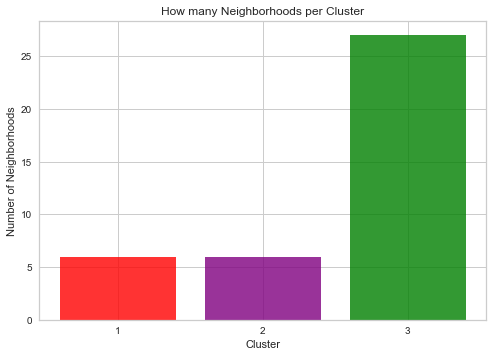

In [58]:
objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = thai_freq2['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')
plt.savefig('data5.png', bbox_inches='tight')
plt.show()

In [59]:
#How many neighborhoods in each cluster
thai_freq2['Cluster Labels'].value_counts()

2    27
1     6
0     6
Name: Cluster Labels, dtype: int64

### Analysis of each cluster

#### Cluster 1

In [60]:
#Creating a dataframe with borough of each neighborhood which will be merged with each cluster dataframe
df_new = toronto_df[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
2,Downtown Toronto,"Regent Park, Harbourfront"
9,Downtown Toronto,"Garden District, Ryerson"
15,Downtown Toronto,St. James Town
19,East Toronto,The Beaches
20,Downtown Toronto,Berczy Park


In [61]:
#Red 
cluster1 = toronto_merge2.loc[toronto_merge2['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.sort_values(["Thai Restaurant"], ascending=False).head(10)

,Borough,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
318,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Thai Express,43.661630,-79.387340,Thai Restaurant
303,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub
335,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Fran's,43.661255,-79.383893,Diner
336,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Hangry Burger,43.660710,-79.382838,Burger Joint
337,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Krispy Kreme Doughnut Cafe,43.655772,-79.391993,Donut Shop
338,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Coco Fresh Tea & Juice,43.658660,-79.382040,Bubble Tea Shop
339,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
340,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
341,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Pumpernickel's @ MaRS,43.660111,-79.388194,Deli / Bodega
342,Downtown Toronto,Central Bay Street,0.032787,0,43.657952,-79.387383,Mo'Ramyun,43.656148,-79.392282,Korean Restaurant


In [62]:
df_cluster1['Venue Category'].value_counts(ascending=False)['Thai Restaurant']

6

#### Cluster 2

In [63]:
#Purple 
cluster2 = toronto_merge2.loc[toronto_merge2['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Thai Restaurant"], ascending=False).head(10)

,Borough,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Freshii,43.649273,-79.383748,Salad Place
58,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,David Pecaut Square,43.646743,-79.387701,Park
67,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Pizzeria Libretto,43.648334,-79.385111,Pizza Place
66,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,John & Sons Oyster House,43.650602,-79.381555,Seafood Restaurant
65,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Friendly Stranger - Cannabis Culture Shop,43.650196,-79.388511,Smoke Shop
64,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Hilton,43.649946,-79.385479,Hotel
63,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,JaBistro,43.649687,-79.388090,Sushi Restaurant
62,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Canadian Opera Company,43.650660,-79.386242,Opera House
61,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Canoe,43.647452,-79.381320,Restaurant
60,Downtown Toronto,"Richmond, Adelaide, King",0.032967,1,43.650571,-79.384568,Daily Press Juicery,43.650388,-79.388792,Juice Bar


In [64]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Thai Restaurant']

8

#### Cluster 3

In [65]:
#Green
cluster3 = toronto_merge2.loc[toronto_merge2['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.sort_values(["Thai Restaurant"], ascending=False).head(10)

,Borough,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
244,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Playa Cabana Cantina,43.665315,-79.465548,Mexican Restaurant
231,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Cool Hand of a Girl,43.665410,-79.462822,Café
220,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Junction Grill,43.665210,-79.468461,Diner
221,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Silk,43.665291,-79.466238,Thai Restaurant
222,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Dollarama,43.665792,-79.465906,Discount Store
223,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Pascal's Baguette & Bagels,43.665426,-79.466176,Bakery
224,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,A&W,43.665520,-79.464731,Fast Food Restaurant
225,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,ROUX,43.665418,-79.462392,Cajun / Creole Restaurant
226,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Chica’s Nashville Hot Chicken,43.665295,-79.464888,Fried Chicken Joint
227,West Toronto,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,La Revolucion,43.665460,-79.464308,Mexican Restaurant


In [66]:
df_cluster3['Venue Category'].value_counts(ascending=False)['Thai Restaurant']

5

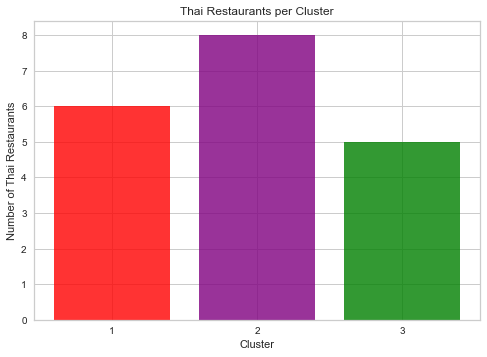

In [67]:
clusters_total = [df_cluster1['Venue Category'].value_counts(ascending=False)['Thai Restaurant'],
                 df_cluster2['Venue Category'].value_counts(ascending=False)['Thai Restaurant'],
                 df_cluster3['Venue Category'].value_counts(ascending=False)['Thai Restaurant']
                 ]
objects = (1,2,3)
y_pos = np.arange(len(objects))
perf = clusters_total
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Number of Thai Restaurants')
plt.xlabel('Cluster')
plt.title('Thai Restaurants per Cluster')
plt.savefig('data6.png', bbox_inches='tight')
plt.show()

### Crime Data

In [68]:
Torcrime = pd.read_csv("Neighbourhood_Crime_Rates_2018-2020.csv")
Torcrime['Neighbourhood']=Torcrime['Neighbourhood'].str.replace('-',', ')
Torcrime = Torcrime.rename(columns={'F2020_Population_Projection':'Population', 'Neighbourhood': 'Neighborhood'})
Torcrime.head()

,Neighborhood,Population,Assault_Rate2018,Assault_Rate2019,Assault_Rate2020,AutoTheft_Rate2018,AutoTheft_Rate2019,AutoTheft_Rate2020,BreakAndEnter_Rate2018,BreakAndEnter_Rate2019,BreakAndEnter_Rate2020,Robbery_Rate2018,Robbery_Rate2019,Robbery_Rate2020,TheftOver_Rate2018,TheftOver_Rate2019,TheftOver_Rate2020,Homicide_Rate2018,Homicide_Rate2019,Homicide_Rate2020,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020
0,"Yonge, St.Clair",14083,207.2846,253.8071,163.3175,44.41812,43.50979,63.90684,177.6725,203.0457,184.6198,7.40302,29.00653,35.50380,22.20906,43.50979,21.30228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,York University Heights,30277,1230.3300,1279.8610,1126.2670,309.28190,492.51180,607.72200,414.6416,371.8967,346.7979,319.47800,281.43530,155.23340,129.15070,103.86300,142.02200,0.000000,0.000000,3.302837,27.189610,20.102520,39.634040
2,"Lansing, Westgate",18146,390.1543,393.5901,534.5530,91.80102,168.68150,242.47770,286.8782,219.2859,214.9234,183.60200,67.47259,60.61942,34.42538,56.22716,49.59771,0.000000,0.000000,0.000000,5.737564,11.245430,5.510856
3,"Yorkdale, Glen Park",17560,1086.5580,1237.4050,888.3827,390.67270,377.11390,495.44420,408.9855,530.3164,461.2756,286.90030,247.48100,227.79040,122.08520,176.77210,102.50570,6.104261,5.892405,5.694761,61.042610,100.170900,79.726650
4,"Stonegate, Queensway",27410,323.2961,307.3277,379.4236,116.53700,129.59600,164.17370,146.6110,236.9756,127.6906,97.74068,88.86585,72.96607,30.07406,14.81098,18.24152,0.000000,0.000000,0.000000,3.759257,3.702744,0.000000


In [69]:
#Calculating the average of each crime
ar = Torcrime.loc[: , "Assault_Rate2018":"Assault_Rate2020"]
Torcrime['Assault_Rate'] = ar.mean(axis=1)

at = Torcrime.loc[: , "AutoTheft_Rate2018":"AutoTheft_Rate2020"]
Torcrime['AutoTheft_Rate'] = at.mean(axis=1)

bne = Torcrime.loc[: , "BreakAndEnter_Rate2018":"BreakAndEnter_Rate2020"]
Torcrime['BreakNEnter_Rate'] = bne.mean(axis=1)

rb = Torcrime.loc[: , "Robbery_Rate2018":"Robbery_Rate2020"]
Torcrime['Robbery_Rate'] = rb.mean(axis=1)

thf = Torcrime.loc[: , "TheftOver_Rate2018":"TheftOver_Rate2020"]
Torcrime['Theft_Rate'] = thf.mean(axis=1)

hm = Torcrime.loc[: , "Homicide_Rate2018":"Homicide_Rate2020"]
Torcrime['Homicide_Rate'] = hm.mean(axis=1)

shoo = Torcrime.loc[: , "Shootings_Rate2018":"Shootings_Rate2020"]
Torcrime['Shootings_Rate'] = shoo.mean(axis=1)

Torcrime.head()

,Neighborhood,Population,Assault_Rate2018,Assault_Rate2019,Assault_Rate2020,AutoTheft_Rate2018,AutoTheft_Rate2019,AutoTheft_Rate2020,BreakAndEnter_Rate2018,BreakAndEnter_Rate2019,BreakAndEnter_Rate2020,Robbery_Rate2018,Robbery_Rate2019,Robbery_Rate2020,TheftOver_Rate2018,TheftOver_Rate2019,TheftOver_Rate2020,Homicide_Rate2018,Homicide_Rate2019,Homicide_Rate2020,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020,Assault_Rate,AutoTheft_Rate,BreakNEnter_Rate,Robbery_Rate,Theft_Rate,Homicide_Rate,Shootings_Rate
0,"Yonge, St.Clair",14083,207.2846,253.8071,163.3175,44.41812,43.50979,63.90684,177.6725,203.0457,184.6198,7.40302,29.00653,35.50380,22.20906,43.50979,21.30228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,208.136400,50.611583,188.446000,23.971117,29.007043,0.000000,0.000000
1,York University Heights,30277,1230.3300,1279.8610,1126.2670,309.28190,492.51180,607.72200,414.6416,371.8967,346.7979,319.47800,281.43530,155.23340,129.15070,103.86300,142.02200,0.000000,0.000000,3.302837,27.189610,20.102520,39.634040,1212.152667,469.838567,377.778733,252.048900,125.011900,1.100946,28.975390
2,"Lansing, Westgate",18146,390.1543,393.5901,534.5530,91.80102,168.68150,242.47770,286.8782,219.2859,214.9234,183.60200,67.47259,60.61942,34.42538,56.22716,49.59771,0.000000,0.000000,0.000000,5.737564,11.245430,5.510856,439.432467,167.653407,240.362500,103.898003,46.750083,0.000000,7.497950
3,"Yorkdale, Glen Park",17560,1086.5580,1237.4050,888.3827,390.67270,377.11390,495.44420,408.9855,530.3164,461.2756,286.90030,247.48100,227.79040,122.08520,176.77210,102.50570,6.104261,5.892405,5.694761,61.042610,100.170900,79.726650,1070.781900,421.076933,466.859167,254.057233,133.787667,5.897142,80.313387
4,"Stonegate, Queensway",27410,323.2961,307.3277,379.4236,116.53700,129.59600,164.17370,146.6110,236.9756,127.6906,97.74068,88.86585,72.96607,30.07406,14.81098,18.24152,0.000000,0.000000,0.000000,3.759257,3.702744,0.000000,336.682467,136.768900,170.425733,86.524200,21.042187,0.000000,2.487334


In [70]:
#Removing extra columns
Torcrime.drop(Torcrime.iloc[:, 2:23], inplace = True, axis = 1)
Torcrime.head()

,Neighborhood,Population,Assault_Rate,AutoTheft_Rate,BreakNEnter_Rate,Robbery_Rate,Theft_Rate,Homicide_Rate,Shootings_Rate
0,"Yonge, St.Clair",14083,208.136400,50.611583,188.446000,23.971117,29.007043,0.000000,0.000000
1,York University Heights,30277,1212.152667,469.838567,377.778733,252.048900,125.011900,1.100946,28.975390
2,"Lansing, Westgate",18146,439.432467,167.653407,240.362500,103.898003,46.750083,0.000000,7.497950
3,"Yorkdale, Glen Park",17560,1070.781900,421.076933,466.859167,254.057233,133.787667,5.897142,80.313387
4,"Stonegate, Queensway",27410,336.682467,136.768900,170.425733,86.524200,21.042187,0.000000,2.487334


In [71]:
#Calculating Total Crime Rate by summing the columns
Crim = Torcrime.loc[: , "Assault_Rate":"Shootings_Rate"]
Torcrime['Crimes_Rate'] = Crim.sum(axis=1)

Torcrime.head()

,Neighborhood,Population,Assault_Rate,AutoTheft_Rate,BreakNEnter_Rate,Robbery_Rate,Theft_Rate,Homicide_Rate,Shootings_Rate,Crimes_Rate
0,"Yonge, St.Clair",14083,208.136400,50.611583,188.446000,23.971117,29.007043,0.000000,0.000000,500.172143
1,York University Heights,30277,1212.152667,469.838567,377.778733,252.048900,125.011900,1.100946,28.975390,2466.907102
2,"Lansing, Westgate",18146,439.432467,167.653407,240.362500,103.898003,46.750083,0.000000,7.497950,1005.594410
3,"Yorkdale, Glen Park",17560,1070.781900,421.076933,466.859167,254.057233,133.787667,5.897142,80.313387,2432.773429
4,"Stonegate, Queensway",27410,336.682467,136.768900,170.425733,86.524200,21.042187,0.000000,2.487334,753.930820


In [72]:
Torcrime0 = Torcrime[['Neighborhood','Crimes_Rate']]
Torcrime0.head()

,Neighborhood,Crimes_Rate
0,"Yonge, St.Clair",500.172143
1,York University Heights,2466.907102
2,"Lansing, Westgate",1005.594410
3,"Yorkdale, Glen Park",2432.773429
4,"Stonegate, Queensway",753.930820


In [73]:
Torcrime0.describe()

,Crimes_Rate
count,140.000000
mean,1212.765159
std,652.673105
min,491.993422
25%,784.045899
50%,1056.308643
75%,1382.436742
max,4556.333070


In [74]:
#Sorting the neighborhoods based on Crime Rate
Torcrime1 = Torcrime0.sort_values(["Crimes_Rate"], ascending=True)

In [75]:
#Save data as csv
Torcrime1.to_csv('Crimes_Rate_Toronto.csv', index=False)
print('File Saved!')

File Saved!


In [76]:
#Exploring top 50 lower crime rates neighborhoods in all of Toronto 
Torcrime1.head(50)

,Neighborhood,Crimes_Rate
126,Steeles,491.993422
0,"Yonge, St.Clair",500.172143
36,Guildwood,563.262814
127,Lawrence Park North,571.106238
21,Centennial Scarborough,582.303423
124,Maple Leaf,622.680181
82,"Eringate, Centennial, West Deane",625.138094
64,"Edenbridge, Humber Valley",627.720897
113,Bayview Village,634.751809
135,Pleasant View,646.067931


In [77]:
toronto_merge1['Neighborhood'].unique()

array(['Berczy Park', 'Brockton, Parkdale Village, Exhibition Place',
       'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport',
       'Central Bay Street', 'Christie', 'Church and Wellesley',
       'Commerce Court, Victoria Hotel', 'Davisville', 'Davisville North',
       'Dufferin, Dovercourt Village', 'Enclave of M4L', 'Enclave of M5E',
       'First Canadian Place, Underground city',
       'Forest Hill North & West', 'Garden District, Ryerson',
       'Harbourfront East, Union Station, Toronto Islands',
       'High Park, The Junction South', 'India Bazaar, The Beaches West',
       'Kensington Market, Chinatown, Grange Park', 'Lawrence Park',
       'Little Portugal, Trinity', 'Moore Park, Summerhill East',
       'North Toronto West', 'Parkdale, Roncesvalles',
       'Regent Park, Harbourfront', 'Richmond, Adelaide, King',
       'Rosedale', 'Roselawn', 'Runnymede, Swansea', 'St. James Town',
       'St. James Town, Cab

In [78]:
#List of Neighborhoods in Cluster 3
toronto_merge1.loc[toronto_merge1['Cluster Labels'] == 2]

,Neighborhood,Thai Restaurant,Cluster Labels
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,2
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,2
4,Christie,0.000000,2
7,Davisville,0.029412,2
8,Davisville North,0.000000,2
9,"Dufferin, Dovercourt Village",0.000000,2
10,Enclave of M4L,0.000000,2
13,Forest Hill North & West,0.000000,2
16,"High Park, The Junction South",0.076923,2
17,"India Bazaar, The Beaches West",0.000000,2


### Comment 

When comparing among the clusters, the 3rd Cluster includes the most number of neighborhoods at 27, but has only 5 Thai restaurants. Thus, cluster 3 seems to be the optimal area for exploring a restaurant business venture. Now, our criteria at the beginning were to find a place with limited number of existing Thai restaurants and safety/security of the neighborhood. When considering both of these criteria, the optimum location to open a new Thai Restaurant seems to be in the neighborhood of Lawrence Park. The second best neighborhood with great potential for growing a new Thai restaurant is The Beaches, and the third best is Rosedale. All three of these locations have no Thai restaurants in it, and they have low/ relatively lower crime rate per 100,000 people. Therefore, investors and stakeholders can open a quality Thai restaurant in these locations because there would be little to no competition and they are comparatively safer than other neighborhoods.